## Analyze surface velocities of a video with velocimetry
This notebook shows how to use a camera configuration, and a video to estimate velocities at the surface. 
It also demonstrates the important impact of filtering of spurious or noisy velocities on the end result. We go through the following steps:

* Read a pre-defined camera configuration from file (we use the one prepared in notebook 1)
* Open a video, and provide the predefined camera configuration to it.
* Project frames to a planar projection
* Estimate surface velocities with Particle Image Velocimetry
* Filter raw velocities using several temporal and spatial filters
* Plot results in the camera objective


In [19]:
import pyorc
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from dask.diagnostics import ProgressBar

### load our camera configuration
If you didn't do notebook 01, first go through that notebook to understand how a camera configuration is made.

Below, the camera configuration is loaded back into memory, and used to open a video file. We only need a couple of seconds video, so we use frame 0 until frame 125 only. 


In [20]:
cam_config = pyorc.load_camera_config("Cinnabar/cinnabar.json")
video_file = "/home/michael/Dropbox/Research/PIV_Testing/DJI_0730.MP4"
video = pyorc.Video(video_file, camera_config=cam_config, start_frame=0, end_frame=125)
video



Filename: /home/michael/Dropbox/Research/PIV_Testing/DJI_0730.MP4
FPS: 29.970030
start frame: 0
end frame: 125
Camera configuration: {
    "crs": "PROJCRS[\"WGS 84 / UTM zone 12N\",BASEGEOGCRS[\"WGS 84\",ENSEMBLE[\"World Geodetic System 1984 ensemble\",MEMBER[\"World Geodetic System 1984 (Transit)\"],MEMBER[\"World Geodetic System 1984 (G730)\"],MEMBER[\"World Geodetic System 1984 (G873)\"],MEMBER[\"World Geodetic System 1984 (G1150)\"],MEMBER[\"World Geodetic System 1984 (G1674)\"],MEMBER[\"World Geodetic System 1984 (G1762)\"],MEMBER[\"World Geodetic System 1984 (G2139)\"],ELLIPSOID[\"WGS 84\",6378137,298.257223563,LENGTHUNIT[\"metre\",1]],ENSEMBLEACCURACY[2.0]],PRIMEM[\"Greenwich\",0,ANGLEUNIT[\"degree\",0.0174532925199433]],ID[\"EPSG\",4326]],CONVERSION[\"UTM zone 12N\",METHOD[\"Transverse Mercator\",ID[\"EPSG\",9807]],PARAMETER[\"Latitude of natural origin\",0,ANGLEUNIT[\"degree\",0.0174532925199433],ID[\"EPSG\",8801]],PARAMETER[\"Longitude of natural origin\",-111,ANGLEUNIT[\"de

### extracting gray scaled frames
You can see the video holds information about the video itself (filename, fps, and so on) but also the camera configuration supplied to it. We can now extract the frames. Without any arguments, the frames are automatically grayscaled and all frames are extracted.

In [21]:
da = video.get_frames()
da

<xarray.DataArray 'frames' (time: 125, y: 2160, x: 3840)>
dask.array<stack, shape=(125, 2160, 3840), dtype=uint8, chunksize=(1, 2160, 3840), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.03337 0.06673 0.1001 ... 4.071 4.104 4.137
  * y        (y) int64 2159 2158 2157 2156 2155 2154 2153 2152 ... 6 5 4 3 2 1 0
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 3833 3834 3835 3836 3837 3838 3839
    xp       (y, x) int64 0 1 2 3 4 5 6 7 ... 3833 3834 3835 3836 3837 3838 3839
    yp       (y, x) int64 2159 2159 2159 2159 2159 2159 2159 ... 0 0 0 0 0 0 0
Attributes:
    camera_shape:   [2160, 3840]
    camera_config:  {\n    "crs": "PROJCRS[\"WGS 84 / UTM zone 12N\",BASEGEOG...
    h_a:            null

The frames object is really a `xarray.DataFrame` object, with some additional functionalities under the method `.frames`. The beauty of our API is that it also uses lazy dask arrays to prevent very lengthy runs that then result in gibberish because of a small mistake along the way. We can see the shape and datatype of the end result, without actually computing everything, until we request a sample. Let's have a look at only the first frame with the plotting functionalities. If you want to use the default plot functionalities of `xarray` simply replace the line below by:
```
da[0].plot(cmap="gray")
```


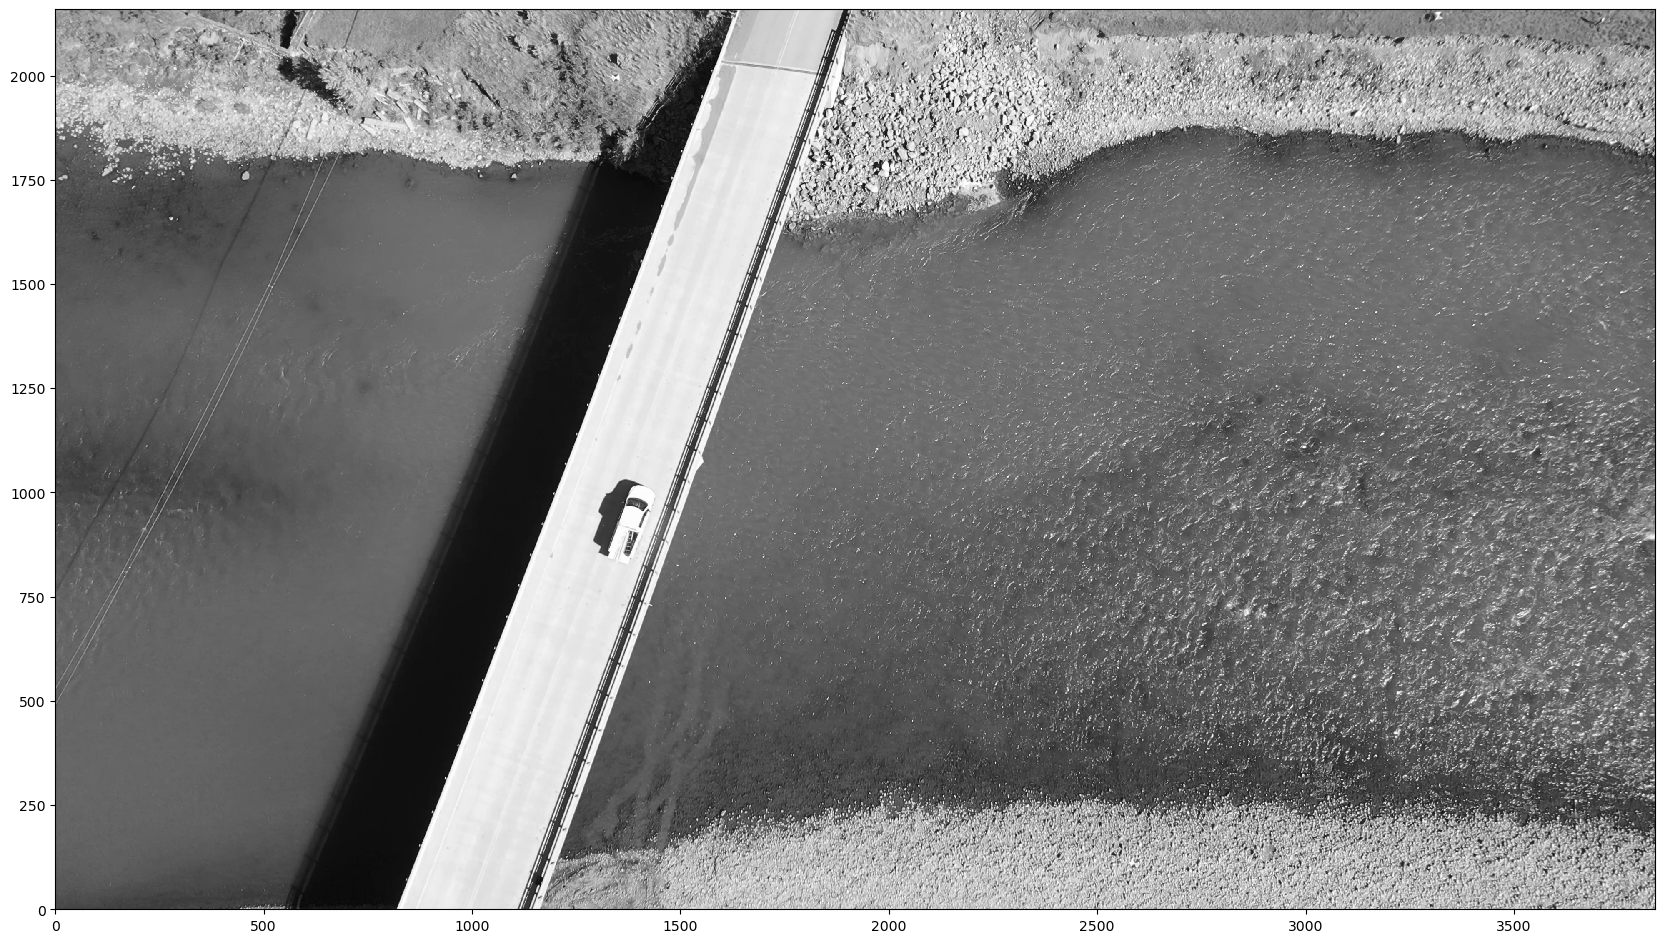

In [22]:
da[0].frames.plot(cmap="gray")

### normalize to add contrast
the `.frames` methods hold functionalities to improve the contrast of the image. A very good step is to remove the average of a larger set of frames from the frames itself, so that only strongly contrasting patterns from the background are left over. These are better traceable. We do this with the `.normalize` method. By default, 15 samples are used.

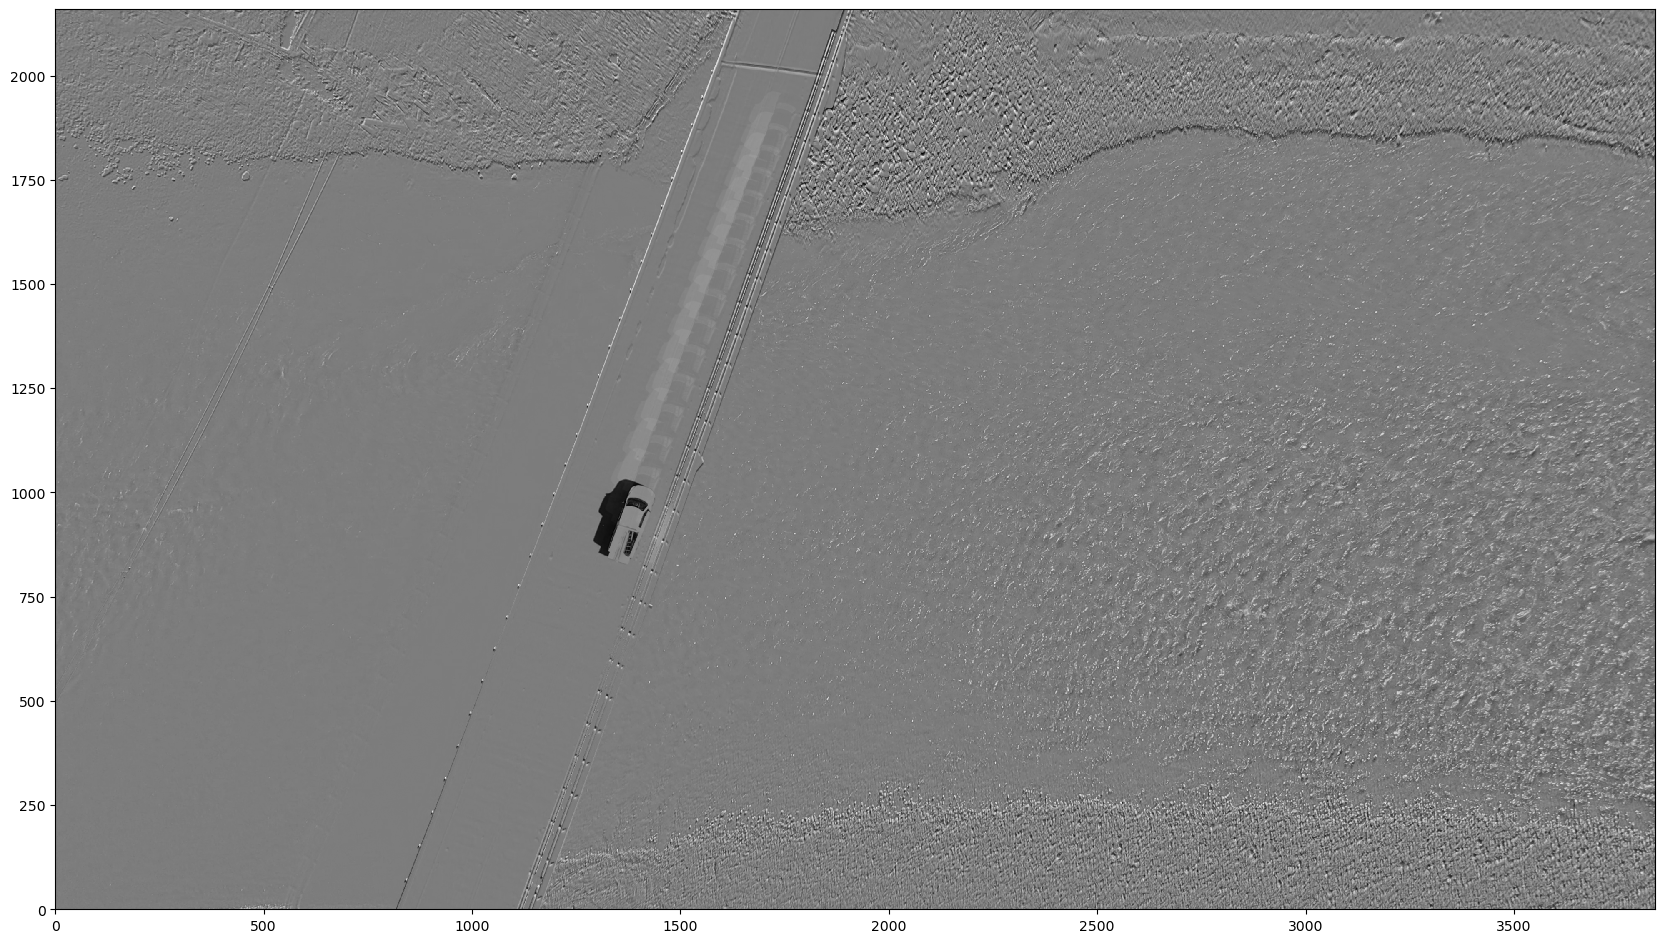

In [23]:
da_norm = da.frames.normalize()
da_norm[0].frames.plot(cmap="gray")


A lot more contrast is visible now. We can now project the frames to an orthoprojected plane. The camera configuration, which is part of the `Video` object is used under the hood to do this.

<Figure size 1600x900 with 0 Axes>

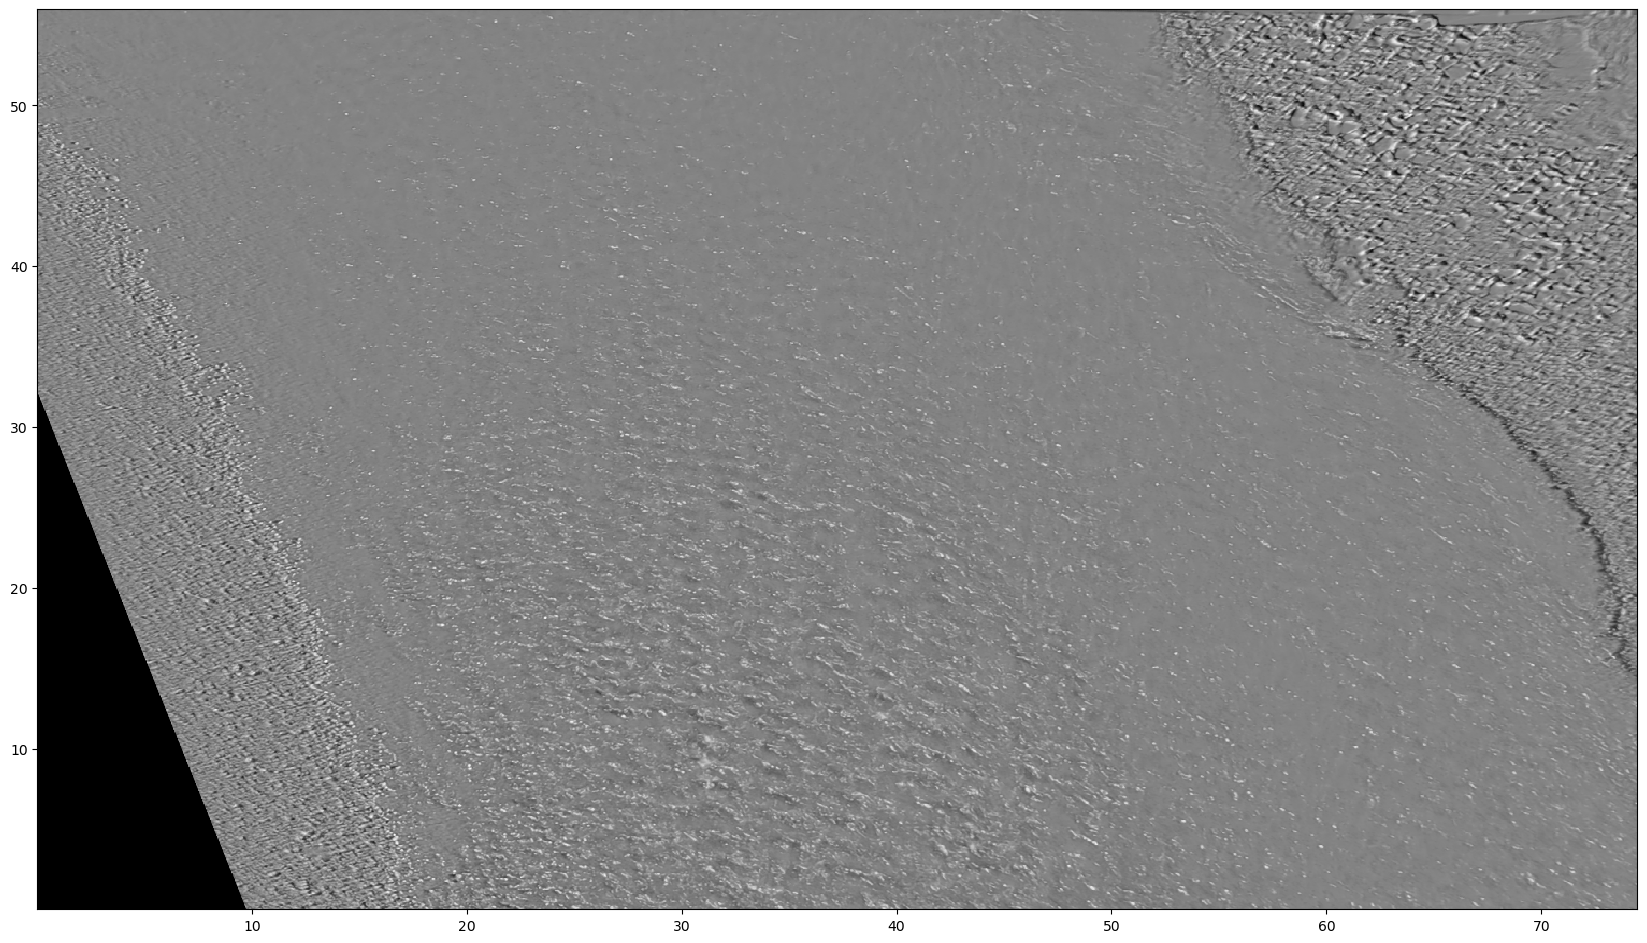

In [24]:
f = plt.figure(figsize=(16, 9))
da_norm_proj = da_norm.frames.project()
da_norm_proj[0].frames.plot(cmap="gray")


You can see that the frames now also have x and y coordinates. These are in fact geographically aware, because we measured control points in real world coordinates and added a coordinate reference system to the `CameraConfig` object (see notebook 01). The `DataArray` therefore also contains coordinate grids for `lon` and `lat` for longitudes and latitudes. Hence we can also go through this entire pipeline with an RGB image and plot this in the real world by adding `mode="geographical"` to the plotting functionalities. The grid is rotated so that its orientation always can follow the stream (in the local projection shown above, left is upstream, right downstream). 
Plotting of an rgb frame geographically is done as follows:


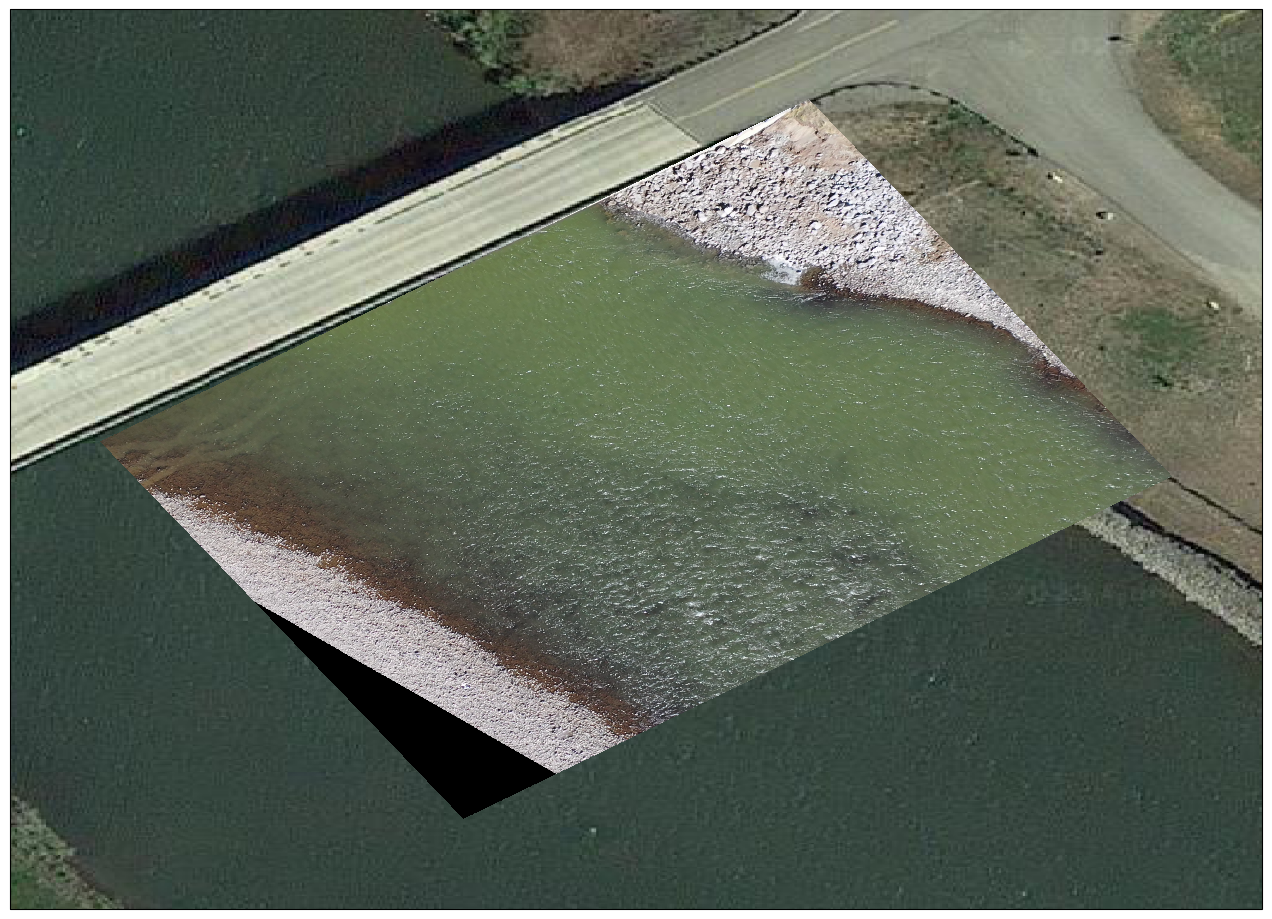

In [25]:
# extract frames again, but now with rgb
da_rgb = video.get_frames(method="rgb")
# project the rgb frames, same as before
da_rgb_proj = da_rgb.frames.project()
# plot the first frame in geographical mode
p = da_rgb_proj[0].frames.plot(mode="geographical")

# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
p.axes.set_extent([
    da_rgb_proj.lon.min() - 0.0001,
    da_rgb_proj.lon.max() + 0.0001,
    da_rgb_proj.lat.min() - 0.0001,
    da_rgb_proj.lat.max() + 0.0001],
    crs=ccrs.PlateCarree()
)


### Velocimetry estimates
Now that we have real-world projected frames, with contrast enhanced, let's do some velocimetry! For Particle Image Velocimetry, this is as simple as calling the `.get_piv` method on the frames. Again a lazy result is returned really fast. If you want to do the computations, you can either extract a single frame, or (as below) store the result in a nice NetCDF file. Note that this file can be loaded back into memory with the `xarray` API without any additional fuss. We use a delayed method for storing, just to see a progress bar. If you are not interested in that, you can also replace the last 3 lines by:
```
piv.to_netcdf("ngwerere_piv.nc")
```


In [26]:
piv = da_norm_proj.frames.get_piv()
delayed_obj = piv.to_netcdf("cinnabar_piv.nc", compute=False)
with ProgressBar():
    results = delayed_obj.compute()


[########################################] | 100% Completed |  2min 51.2s


### Beautiful additions to your art gallery
Of course now we want to do some plotting and filtering, for that, please go to the next notebook